In [67]:
import sys
print(sys.path)
sys.path.append('/home/zinovyev/anaconda3/lib/python3.7/site-packages')
sys.path.append('/home/zinovyev/anaconda3/lib/python3.7/site-packages/skdim/')
print(sys.path)


['/mnt/c/Datas/SingleCellTranscriptomics/RNAVelocity', '/usr/lib/python37.zip', '/usr/lib/python3.7', '/usr/lib/python3.7/lib-dynload', '', '/home/zinovyev/.local/lib/python3.7/site-packages', '/usr/local/lib/python3.7/dist-packages', '/usr/lib/python3/dist-packages', '/home/zinovyev/.local/lib/python3.7/site-packages/IPython/extensions', '/home/zinovyev/.ipython']
['/mnt/c/Datas/SingleCellTranscriptomics/RNAVelocity', '/usr/lib/python37.zip', '/usr/lib/python3.7', '/usr/lib/python3.7/lib-dynload', '', '/home/zinovyev/.local/lib/python3.7/site-packages', '/usr/local/lib/python3.7/dist-packages', '/usr/lib/python3/dist-packages', '/home/zinovyev/.local/lib/python3.7/site-packages/IPython/extensions', '/home/zinovyev/.ipython', '/home/zinovyev/anaconda3/lib/python3.7/site-packages', '/home/zinovyev/anaconda3/lib/python3.7/site-packages/skdim/']


In [330]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scvelo as sv
import anndata
import scanpy as sc
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA

def ismember(A, B):
    dct = {}
    for s,i in enumerate(B):
        dct[i] = s
    return [ dct[a] for a in A ]

def load_signature_file(file):
    sigs = {}
    with open(file,'r',encoding="utf8",errors='ignore') as fin:
        line = fin.readline().strip('\n').strip(' ')
        while line:
            parts = line.split('\t')
            lst = parts[2:]
            lst = [s.split('[')[0] for s in lst if not s=='']
            sigs[parts[0]] = lst
            line = fin.readline().strip('\n').strip(' ')
    return sigs

def load_weighted_signature_file(file):
    sigs = {}
    with open(file,'r',encoding="utf8",errors='ignore') as fin:
        line = fin.readline().strip('\n').strip(' ')
        while line:
            parts = line.split('\t')
            lst = parts[2:]
            lst1 = [s.split('[')[0] for s in lst if not s=='']
            weights = [float(s.split('[')[1].split(']')[0]) for s in lst if not s=='']
            #print(lst1,weights)
            sigs[parts[0]] = (lst1,weights)
            #sigs[parts[0]+'_W'] = weights
            line = fin.readline().strip('\n').strip(' ')
    return sigs

def calc_scores(anndata,signature_dict):
    matrix = anndata.to_df().to_numpy()
    scores_dic = {}
    for key in signature_dict:
        names = np.array(signature_dict[key])
        inds = np.where(np.isin(anndata.var_names,names))[0]
        matrix_sel = matrix[:,inds]
        scores = np.mean(matrix_sel,axis=1)
        scores_dic[key] = scores
    return scores_dic

def calc_weighted_scores(anndata,signature_dict):
    matrix = anndata.to_df().to_numpy()
    scores_dic = {}
    for key in signature_dict:
        names_weights = signature_dict[key]
        names = names_weights[0]
        weights = np.array(names_weights[1])
        inds = np.where(np.isin(anndata.var_names,names))[0]
        sel_names = anndata.var_names[inds]
        ind_in_names = ismember(sel_names,names)
        names1 = np.array(names)[ind_in_names]
        weights1 = np.array(weights)[ind_in_names]
        inds = ismember(names1,anndata.var_names)
        matrix_sel = matrix[:,inds]
        gene_means = np.mean(matrix_sel,axis=0)
        meanmat = np.outer(np.ones(matrix_sel.shape[0]),gene_means)
        matrix_sel = matrix_sel-meanmat
        scores = np.matmul(matrix_sel,weights1)
        scores_dic[key] = scores
    return scores_dic


def calc_histone_score(adata2k):
    histone_names1 = np.argwhere(adata2k.var_names.str.startswith('H1'))
    histone_names2 = np.argwhere(adata2k.var_names.str.startswith('H2'))
    histone_names3 = np.argwhere(adata2k.var_names.str.startswith('H3'))
    histone_names4 = np.argwhere(adata2k.var_names.str.startswith('H4'))
    histone_names5 = np.argwhere(adata2k.var_names.str.startswith('HIST'))
    histone_names = np.union1d(np.union1d(histone_names1,histone_names2),np.union1d(histone_names3,histone_names4))
    histone_names = np.union1d(histone_names,histone_names5)
    histone_names = adata2k.var_names[histone_names]
    print('Found histone genes:',*histone_names)
    inds_histones = np.where(np.isin(adata2k.var_names,histone_names))[0]
    matrix = adata2k.to_df().to_numpy()
    matrix_sel = matrix[:,inds_histones]
    scores = np.mean(matrix_sel,axis=1)
    return scores

def smooth_adata_by_pooling(adata,X_embed,n_neighbours=10):
    adata_pooled = adata.copy()
    nbrs = NearestNeighbors(n_neighbors=n_neighbours).fit(X_embed)
    distances, indices = nbrs.kneighbors(X_embed)    
    adata_pooled.X = smooth_matrix_by_pooling(get_nd_array(adata.X),indices)
    if 'matrix' in adata.layers:
        adata_pooled.layers['matrix'] = smooth_matrix_by_pooling(get_nd_array(adata.layers['matrix']),indices)
    if 'spliced' in adata.layers:
        adata_pooled.layers['spliced'] = smooth_matrix_by_pooling(get_nd_array(adata.layers['spliced']),indices)
    if 'unspliced' in adata.layers:
        adata_pooled.layers['unspliced'] = smooth_matrix_by_pooling(get_nd_array(adata.layers['unspliced']),indices)
    return adata_pooled

def smooth_matrix_by_pooling(matrix,indices):
    matrix_pooled = matrix.copy()
    for i in range(len(indices)):
        matrix_pooled[i,:] = np.mean(matrix[indices[i],:],axis=0)
    return matrix_pooled

def get_nd_array(arr):
    x = None
    if str(type(arr)):
        x = arr
    else:
        x = arr.toarray()
    return x

    
def preprocessing_without_pooling(adata):
    if not Already_Log_Transformed:
        sc.pp.log1p(adata)
    if Normalize_Totals:
        sc.pp.normalize_total(adata, target_sum=10000)
    if top_variable_genes>0:
        #sc.pp.highly_variable_genes(adata,n_top_genes=top_variable_genes,n_bins=20)
        #ind_genes = np.where(adata.var['highly_variable'])[0]
        vars = np.var(adata.X,axis=0)
        inds = np.flip(np.argsort(vars))
        ind_genes = inds[0:top_variable_genes]
        if 0 in vars[ind_genes]:
            ind_first_zero = np.argwhere(vars[ind_genes]==0)[0][0]
            ind_genes = ind_genes[0:ind_first_zero]
        #print(vars[ind_genes])
        adata = adata[:,ind_genes]
    sc.tl.pca(adata,n_comps=number_of_pcs)
    return adata

# pooling procedure
def pooling_procedure(adata,adata_orig):
    if n_neighbours_for_pooling>0:    
        adata_work = adata_orig.copy()
        preprocessing_without_pooling(adata)
        sc.tl.pca(adata,n_comps=number_of_pcs)
        X_pca = adata.obsm['X_pca']
        adata = smooth_adata_by_pooling(adata_work,X_pca,n_neighbours=n_neighbours_for_pooling)
    return adata

def preprocessing_dataset(adata):
    adata = preprocessing_without_pooling(adata)    
    sc.tl.pca(adata,n_comps=number_of_pcs)
    display(adata)
    return adata




In [16]:
folder = '/mnt/c/Datas/SingleCellTranscriptomics/Broad_CellLine/'

metadata = pd.read_csv(folder+'metadata_header.txt',delimiter='\t')

display(metadata)

cancer_types = list(metadata['Cancer_type'])
cell_lines = list(metadata['Cell_line'])
cellnames = list(metadata['NAME'])

cancer_types_unique = list(set(cancer_types))
print(cancer_types_unique)

for v in cancer_types_unique:
    print(v,':',cancer_types.count(v))

/home/zinovyev/.local/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,NAME,Cell_line,Pool_ID,Cancer_type,Genes_expressed,Discrete_cluster_minpts5_eps1.8,Discrete_cluster_minpts5_eps1.5,Discrete_cluster_minpts5_eps1.2,CNA_subclone,SkinPig_score,...,EMTII_score,EMTIII_score,IFNResp_score,p53Sen_score,EpiSen_score,StressResp_score,ProtMatu_score,ProtDegra_score,G1/S_score,G2/M_score
0,AAACCTGAGACATAAC-1-18,NCIH2126_LUNG,18,Lung Cancer,4318,NaN,NaN,NaN,NaN,0.166,...,-0.935,-0.935,0.130,0.619,1.869,-0.004,0.805,0.896,0.424,-1.125
1,AACGTTGTCACCCGAG-1-18,NCIH2126_LUNG,18,Lung Cancer,5200,NaN,NaN,NaN,NaN,-0.213,...,-1.027,-1.027,0.066,1.049,1.267,0.252,1.299,1.610,0.624,-0.048
2,AACTGGTAGACACGAC-1-18,NCIH2126_LUNG,18,Lung Cancer,4004,NaN,NaN,NaN,NaN,-0.101,...,-0.677,-0.677,0.304,0.822,2.401,0.141,0.451,1.225,-0.795,0.064
3,AACTGGTAGGGCTTGA-1-18,NCIH2126_LUNG,18,Lung Cancer,4295,NaN,NaN,NaN,NaN,-0.014,...,-0.735,-0.735,0.094,0.834,2.282,0.150,0.267,0.892,-0.238,1.118
4,AACTGGTAGTACTTGC-1-18,NCIH2126_LUNG,18,Lung Cancer,4842,NaN,NaN,NaN,NaN,0.006,...,-0.821,-0.821,0.034,0.960,1.400,-0.012,-0.276,-0.428,0.267,0.791
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53508,c4722,JHU006_UPPER_AERODIGESTIVE_TRACT,custom,Head and Neck Cancer,3343,NaN,NaN,NaN,NaN,0.018,...,-0.505,-0.505,1.657,1.583,3.850,0.539,0.473,0.544,-1.079,-1.349
53509,c4724,JHU006_UPPER_AERODIGESTIVE_TRACT,custom,Head and Neck Cancer,6977,NaN,NaN,NaN,NaN,-0.098,...,-0.876,-0.876,0.669,1.086,3.046,0.799,0.490,1.319,-0.370,0.057
53510,c4731,JHU006_UPPER_AERODIGESTIVE_TRACT,custom,Head and Neck Cancer,6638,NaN,NaN,NaN,NaN,-0.112,...,-0.112,-0.112,0.610,0.693,2.289,0.650,0.729,1.143,-0.508,0.501
53511,c4735,JHU006_UPPER_AERODIGESTIVE_TRACT,custom,Head and Neck Cancer,4052,NaN,NaN,NaN,NaN,-0.244,...,1.981,1.981,0.523,-0.309,0.267,0.822,1.049,0.777,0.296,-0.936


['Breast Cancer', 'Skin Cancer', 'Head and Neck Cancer', 'Bladder Cancer', 'Prostate Cancer', 'Lung Cancer', 'Neuroblastoma', 'Brain Cancer', 'Ovarian Cancer', 'Endometrial/Uterine Cancer', 'Gallbladder Cancer', 'Bone Cancer', 'Sarcoma', 'Bile Duct Cancer', 'Gastric Cancer', 'Kidney Cancer', 'Liver Cancer', 'Esophageal Cancer', 'Pancreatic Cancer', 'Colon/Colorectal Cancer', 'Fibroblast', 'Thyroid Cancer']
Breast Cancer : 3285
Skin Cancer : 5351
Head and Neck Cancer : 7102
Bladder Cancer : 1291
Prostate Cancer : 298
Lung Cancer : 12842
Neuroblastoma : 355
Brain Cancer : 2967
Ovarian Cancer : 2495
Endometrial/Uterine Cancer : 2057
Gallbladder Cancer : 94
Bone Cancer : 1030
Sarcoma : 1027
Bile Duct Cancer : 739
Gastric Cancer : 1270
Kidney Cancer : 1561
Liver Cancer : 1550
Esophageal Cancer : 2544
Pancreatic Cancer : 2368
Colon/Colorectal Cancer : 2104
Fibroblast : 215
Thyroid Cancer : 968


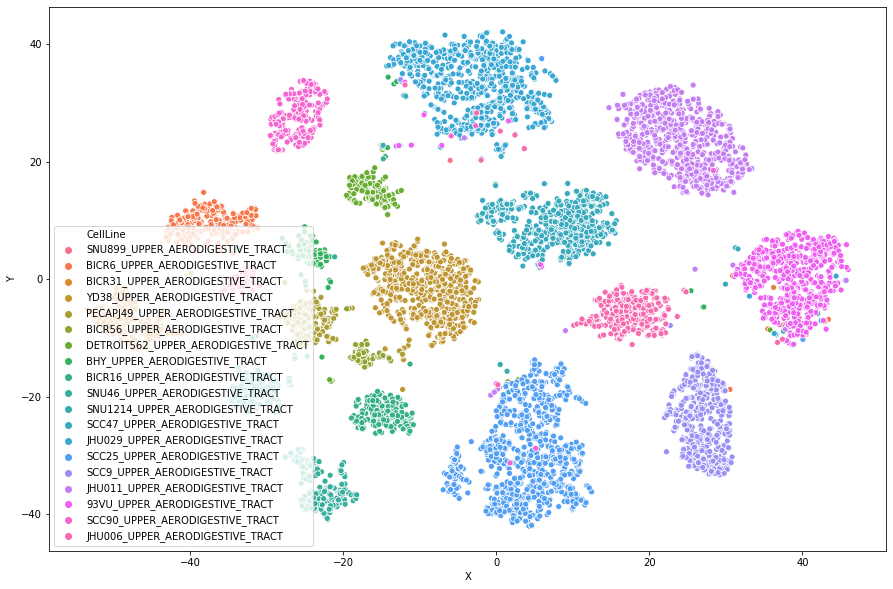

In [58]:
# Extract a dataset
tp = 'Head and Neck Cancer'
ind = np.where(np.array(cancer_types)==tp)[0]
tsne = pd.read_csv(folder+'tSNE_'+tp.replace(' ','_')+'.txt',delimiter='\t')
tsne['CellLine'] = np.array(cell_lines)[ind]
plt.figure(figsize=(15,10))
sns.scatterplot('X', 'Y', data=tsne,hue='CellLine')
plt.show()

with open(folder+'CPM_data.txt') as fin, open(folder+tp.replace(' ','_')+'.txt','w') as fout:
    header = fin.readline()[:-1]
    cells = np.array(header.split('\t'))
    ind_cells = ismember(cells_of_type,cells)
    ind_cells = [0]+ind_cells
    fout.write('\t'.join(cells[ind_cells])+'\n')
    ln = fin.readline()[:-1]
    while ln:
        cells = ln.split('\t')
        selected_vals = np.array(cells)[ind_cells[1:]]
        selected_vals = [str(int(float(s))) for s in selected_vals]
        fout.write(cells[0]+'\t'+'\t'.join(selected_vals)+'\n')
        ln = fin.readline()[:-1]
        
with open(folder+tp.replace(' ','_')+'_annotation.txt','w') as fout:
    fout.write('CELL\tCELLLINE\n')
    for i in ind:
        fout.write(cellnames[i]+'\t'+cell_lines[i]+'\n')



In [125]:
# make h5ad file
file = tp.replace(' ','_')
df = pd.read_csv(folder+file+'.txt',delimiter='\t')
annot = pd.read_csv(folder+file+'_annotation.txt',delimiter='\t')
annotl = list(annot[annot.columns[1]])
adata = sc.AnnData(X=df[df.columns[1:]].to_numpy().transpose())
adata.obs_names = list(df.columns[1:])
adata.var_names = list(df[df.columns[0]])
adata.obs['CellLine'] = np.array(annotl)
adata.X = adata.X/10
print(adata)
adata.write(folder+file+'.h5ad',compression='gzip')
adata_orig = adata.copy()

... storing 'CellLine' as categorical


AnnData object with n_obs × n_vars = 7102 × 22722
    obs: 'CellLine'


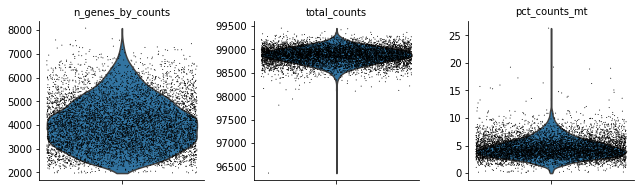

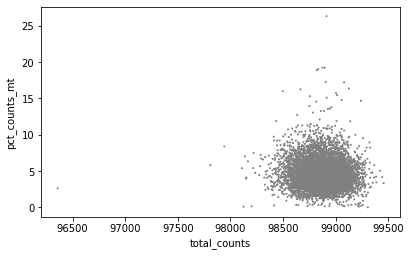

AnnData object with n_obs × n_vars = 7102 × 22722
    obs: 'CellLine', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'


In [130]:
# loading h5ad file
adata_orig = sc.read_h5ad(folder+file+'.h5ad')
adata_orig.var['mt'] = adata_orig.var_names.str.startswith('MT-')
sc.pp.calculate_qc_metrics(adata_orig, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
sc.pl.violin(adata_orig, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'], jitter=0.4, multi_panel=True)
sc.pl.scatter(adata_orig, x='total_counts', y='pct_counts_mt')
print(adata_orig)


In [131]:
# pre-processing

adata = adata_orig.copy()

top_variable_genes = 10000 # if negative then no selection of genes
Normalize_Totals = False
Already_Log_Transformed = False
n_neighbours_for_pooling = 10
number_of_pcs = 30

print('PREPROCESSING PARAMETERS:')
print('Already_Log_Transformed=',Already_Log_Transformed)
print('Normalize_Totals=',Normalize_Totals)
print('number_of_pcs=',number_of_pcs)
print('n_neighbours_for_pooling=',n_neighbours_for_pooling)
print('top_variable_genes=',top_variable_genes)

if n_neighbours_for_pooling>0:
    adata = pooling_procedure(adata,adata_orig)
adata = preprocessing_dataset(adata)

adata.write(folder+file+'_processed.h5ad',compression='gzip')

PREPROCESSING PARAMETERS:
Already_Log_Transformed= False
Normalize_Totals= False
number_of_pcs= 30
n_neighbours_for_pooling= 10
top_variable_genes= 10000


AnnData object with n_obs × n_vars = 7102 × 10000
    obs: 'CellLine', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'log1p', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

In [415]:
# Extract cell line datasets

cellline_unique = list(set(cell_lines))
k = 1
for v in cellline_unique:
    n = cell_lines.count(v)
    if n>500:
        print(k,v,':',n)
        k=k+1
        ind_cell_line = np.where(np.array(cell_lines)==v)[0]
        with open(folder+'CPM_data.txt') as fin, open(folder+v+'_raw.txt','w') as fout:
            header = fin.readline()[:-1]
            cells = np.array(header.split('\t'))
            ind_cells = [0]+list(ind_cell_line+1)
            fout.write('\t'.join(cells[ind_cells])+'\n')
            ln = fin.readline()[:-1]
            while ln:
                cells = ln.split('\t')
                selected_vals = np.array(cells)[ind_cells[1:]]
                selected_vals = [str(int(float(s))) for s in selected_vals]
                fout.write(cells[0]+'\t'+'\t'.join(selected_vals)+'\n')
                ln = fin.readline()[:-1]
       
        
#        adata_k = adata_orig[ind_cell_line,:]
#        adata_k1 = adata_k.copy()
#        if n_neighbours_for_pooling>0:
#            adata_k1 = pooling_procedure(adata_k1,adata_k)
#        adata_k1 = preprocessing_dataset(adata_k1)
#        dc = {'GENE',adata_k1.var_names}
#        for j,s in enumerate(adata_k1.obs_names):
#            dc[s] = adata_k1.X[j,:]
#        pd.DataFrame(data=dc).to_csv(folder+v+'_row.txt',sep='\t',index=False)


1 JHU011_UPPER_AERODIGESTIVE_TRACT : 717
2 NCIH2452_PLEURA : 538
3 42MGBA_CENTRAL_NERVOUS_SYSTEM : 518
4 93VU_UPPER_AERODIGESTIVE_TRACT : 572
5 SCC47_UPPER_AERODIGESTIVE_TRACT : 592
6 PANC0203_PANCREAS : 506
7 JHU029_UPPER_AERODIGESTIVE_TRACT : 797
8 SCC25_UPPER_AERODIGESTIVE_TRACT : 898
9 YD38_UPPER_AERODIGESTIVE_TRACT : 624
10 C32_SKIN : 554
11 A375_SKIN : 593
12 HT1080_SOFT_TISSUE : 516
13 RERFLCAI_LUNG : 763
14 NCIH2110_LUNG : 1990
15 TE6_OESOPHAGUS : 551
16 NCIH460_LUNG : 837
17 HOS_BONE : 829
18 NCIH1299_LUNG : 534
19 COLO680N_OESOPHAGUS : 523
20 IGR1_SKIN : 725


In [421]:
cellline_unique = list(set(cell_lines))
k = 1
for v in cellline_unique:
    n = cell_lines.count(v)
    if n>500:
        print(k,v,':',n)
        k=k+1
        df = pd.read_csv(folder+v+'_raw.txt',delimiter='\t')
        adata_k = sc.AnnData(X=df[df.columns[1:]].to_numpy().transpose())
        adata_k.obs_names = list(df.columns[1:])
        adata_k.var_names = list(df[df.columns[0]])
        adata_k.X = adata_k.X/10
        if n_neighbours_for_pooling>0:
            adata_k1 = pooling_procedure(adata_k,adata_k)
        adata_k1 = preprocessing_dataset(adata_k1)
        dc = {'GENE':list(adata_k1.var_names)}
        for j,s in enumerate(adata_k1.obs_names):
            dc[s] = adata_k1.X[j,:]
        pd.DataFrame(data=dc).to_csv(folder+v+'_proc.txt',sep='\t',index=False)
  

1 JHU011_UPPER_AERODIGESTIVE_TRACT : 717


AnnData object with n_obs × n_vars = 717 × 10000
    uns: 'log1p', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

2 NCIH2452_PLEURA : 538


AnnData object with n_obs × n_vars = 538 × 10000
    uns: 'log1p', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

3 42MGBA_CENTRAL_NERVOUS_SYSTEM : 518


AnnData object with n_obs × n_vars = 518 × 10000
    uns: 'log1p', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

4 93VU_UPPER_AERODIGESTIVE_TRACT : 572


AnnData object with n_obs × n_vars = 572 × 10000
    uns: 'log1p', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

5 SCC47_UPPER_AERODIGESTIVE_TRACT : 592


AnnData object with n_obs × n_vars = 592 × 10000
    uns: 'log1p', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

6 PANC0203_PANCREAS : 506


AnnData object with n_obs × n_vars = 506 × 10000
    uns: 'log1p', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

7 JHU029_UPPER_AERODIGESTIVE_TRACT : 797


AnnData object with n_obs × n_vars = 797 × 10000
    uns: 'log1p', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

8 SCC25_UPPER_AERODIGESTIVE_TRACT : 898


AnnData object with n_obs × n_vars = 898 × 10000
    uns: 'log1p', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

9 YD38_UPPER_AERODIGESTIVE_TRACT : 624


AnnData object with n_obs × n_vars = 624 × 10000
    uns: 'log1p', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

10 C32_SKIN : 554


AnnData object with n_obs × n_vars = 554 × 10000
    uns: 'log1p', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

11 A375_SKIN : 593


AnnData object with n_obs × n_vars = 593 × 10000
    uns: 'log1p', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

12 HT1080_SOFT_TISSUE : 516


AnnData object with n_obs × n_vars = 516 × 10000
    uns: 'log1p', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

13 RERFLCAI_LUNG : 763


AnnData object with n_obs × n_vars = 763 × 10000
    uns: 'log1p', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

14 NCIH2110_LUNG : 1990


AnnData object with n_obs × n_vars = 1990 × 10000
    uns: 'log1p', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

15 TE6_OESOPHAGUS : 551


AnnData object with n_obs × n_vars = 551 × 10000
    uns: 'log1p', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

16 NCIH460_LUNG : 837


AnnData object with n_obs × n_vars = 837 × 10000
    uns: 'log1p', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

17 HOS_BONE : 829


AnnData object with n_obs × n_vars = 829 × 10000
    uns: 'log1p', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

18 NCIH1299_LUNG : 534


AnnData object with n_obs × n_vars = 534 × 10000
    uns: 'log1p', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

19 COLO680N_OESOPHAGUS : 523


AnnData object with n_obs × n_vars = 523 × 10000
    uns: 'log1p', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

20 IGR1_SKIN : 725


AnnData object with n_obs × n_vars = 725 × 10000
    uns: 'log1p', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

In [133]:
sc.tl.pca(adata,n_comps=number_of_pcs)
sc.pp.neighbors(adata, n_neighbors=10)
sc.tl.umap(adata)
sc.tl.tsne(adata,perplexity=50)

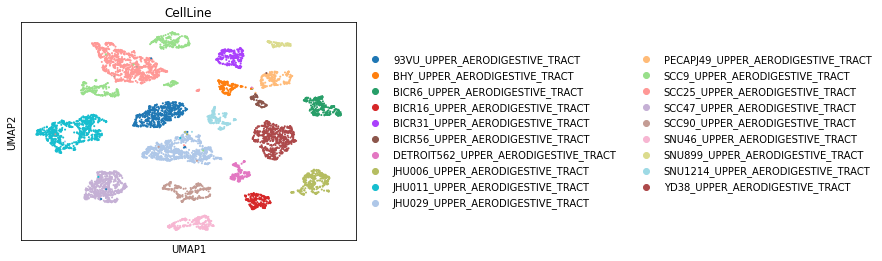

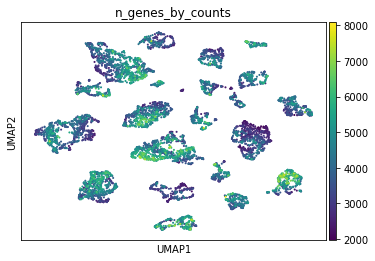

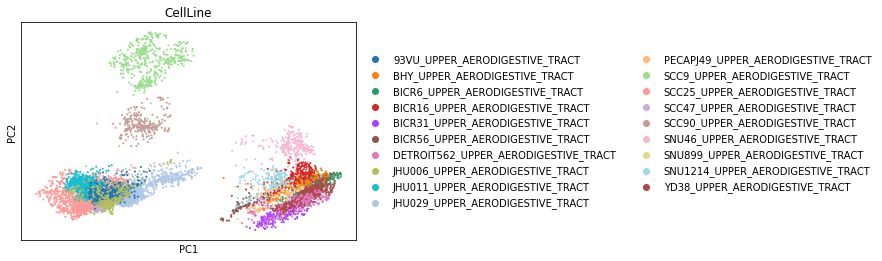

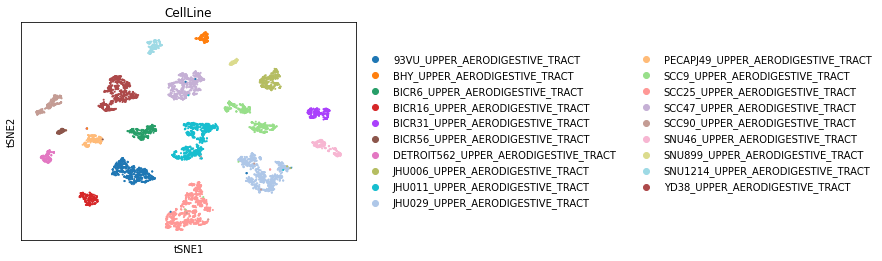

In [134]:
sc.pl.umap(adata,color='CellLine')
sc.pl.umap(adata,color='n_genes_by_counts')
sc.pl.pca(adata,color='CellLine')
sc.pl.tsne(adata,color='CellLine')

In [151]:
# make gmt file from _S file
#sfile = folder+'Head_and_Neck_Cancer_nufp10k_ica_S.xls'
sfile = folder+'JHU011_UPPER_AERODIGESTIVE_TRACT_ica_S.xls'
prefix = 'hn_'
threshold = 3
dfs = pd.read_csv(sfile,delimiter='\t')
dfs1 = dfs[dfs.columns[1:-1]]
gmtfile = sfile[:-4]+'.gmt'
with open(gmtfile,'w') as fout:
    for s in dfs1.columns:
        fout.write(prefix+s+'\tna\t')
        for i in range(dfs[s].shape[0]):
            val = float(dfs[s].iloc[i])
            gn = dfs[dfs.columns[0]].iloc[i]
            if val>threshold:
                fout.write(gn+'\t')
        fout.write('\n')
                
signature_dict = load_signature_file(gmtfile)
sc.pp.highly_variable_genes(adata,n_top_genes=2001,n_bins=20)
ind_genes2k = np.where(adata.var['highly_variable'])[0]
adata2k = adata[:,ind_genes2k]
scores_dic = calc_scores(adata2k,signature_dict)
scores_dic['HISTONES'] = calc_histone_score(adata2k)


for s in scores_dic:
    adata.obs[s] = scores_dic[s]

Found histone genes: HIST1H2BK H1FX HIST1H4C H2AFX HIST3H2A HIST1H2AC HIST1H2BD HIST1H1D HIST1H1C HIST2H2AC HIST1H1E HIST1H1A HIST1H1B HIST1H2BJ HIST1H2BC HIST1H2BH HIST1H2BG HIST1H2AE HIST2H2BE HIST1H2BN HIST1H3G HIST1H4H


In [172]:
# make weighted gmt file from _S file
#sfile = 'ht29_ic15_S.xls'
sfile = folder+'JHU011_UPPER_AERODIGESTIVE_TRACT_ica_S.xls'
prefix = 'hn_'
threshold = 2
dfs = pd.read_csv(sfile,delimiter='\t')
dfs1 = dfs[dfs.columns[1:-1]]
gmtfile = sfile[:-4]+'_weighted.gmt'
with open(gmtfile,'w') as fout:
    for s in dfs1.columns:
        fout.write(prefix+s+'\tna\t')
        for i in range(dfs[s].shape[0]):
            val = float(dfs[s].iloc[i])
            gn = dfs[dfs.columns[0]].iloc[i]
            if abs(val)>threshold:
                fout.write(gn+'['+str(val)+']'+'\t')
        fout.write('\n')
                
signature_dict = load_weighted_signature_file(gmtfile)
sc.pp.highly_variable_genes(adata,n_top_genes=10001,n_bins=20)
ind_genes2k = np.where(adata.var['highly_variable'])[0]
adata2k = adata[:,ind_genes2k]
scores_dic = calc_weighted_scores(adata2k,signature_dict)
scores_dic['HISTONES'] = calc_histone_score(adata2k)

for s in scores_dic:
    adata.obs[s] = scores_dic[s]

Found histone genes: HIST1H2BK H1FX HIST1H4C H2AFX HIST3H2A HIST1H2AC HIST1H2BD HIST1H1D HIST1H1C H1F0 HIST2H2AC HIST1H1E HIST1H1A HIST1H1B HIST1H2BJ HIST1H2BC H2AFY2 HIST1H2BH H2AFJ H2AFZ HIST1H2BG HIST1H2AE HIST2H2BE HIST1H2BN HIST1H3G H3F3A H3F3C H2AFV HIST1H4H H3F3B H2AFY HIST1H3H HIST1H2AG


AnnData object with n_obs × n_vars = 7102 × 10000
    obs: 'CellLine', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'hn_IC1', 'hn_IC2', 'hn_IC3', 'hn_IC4', 'hn_IC5', 'hn_IC6', 'hn_IC7', 'hn_IC8', 'hn_IC9', 'hn_IC10', 'hn_IC11', 'hn_IC12', 'hn_IC13', 'hn_IC14', 'hn_IC15', 'HISTONES'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'pca', 'neighbors', 'umap', 'CellLine_colors'
    obsm: 'X_pca', 'X_umap', 'X_tsne'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'


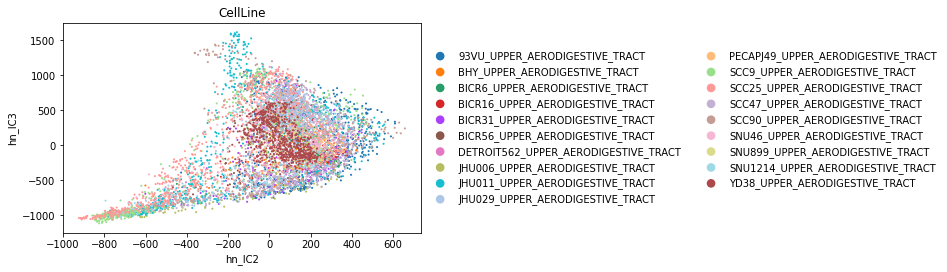

YD38_UPPER_AERODIGESTIVE_TRACT : 624
BICR6_UPPER_AERODIGESTIVE_TRACT : 286
PECAPJ49_UPPER_AERODIGESTIVE_TRACT : 202
BICR31_UPPER_AERODIGESTIVE_TRACT : 248
93VU_UPPER_AERODIGESTIVE_TRACT : 572
SCC47_UPPER_AERODIGESTIVE_TRACT : 592
JHU006_UPPER_AERODIGESTIVE_TRACT : 325
SCC90_UPPER_AERODIGESTIVE_TRACT : 258
BICR16_UPPER_AERODIGESTIVE_TRACT : 212
SCC9_UPPER_AERODIGESTIVE_TRACT : 475
SNU46_UPPER_AERODIGESTIVE_TRACT : 236
JHU029_UPPER_AERODIGESTIVE_TRACT : 797
SCC25_UPPER_AERODIGESTIVE_TRACT : 898
JHU011_UPPER_AERODIGESTIVE_TRACT : 717


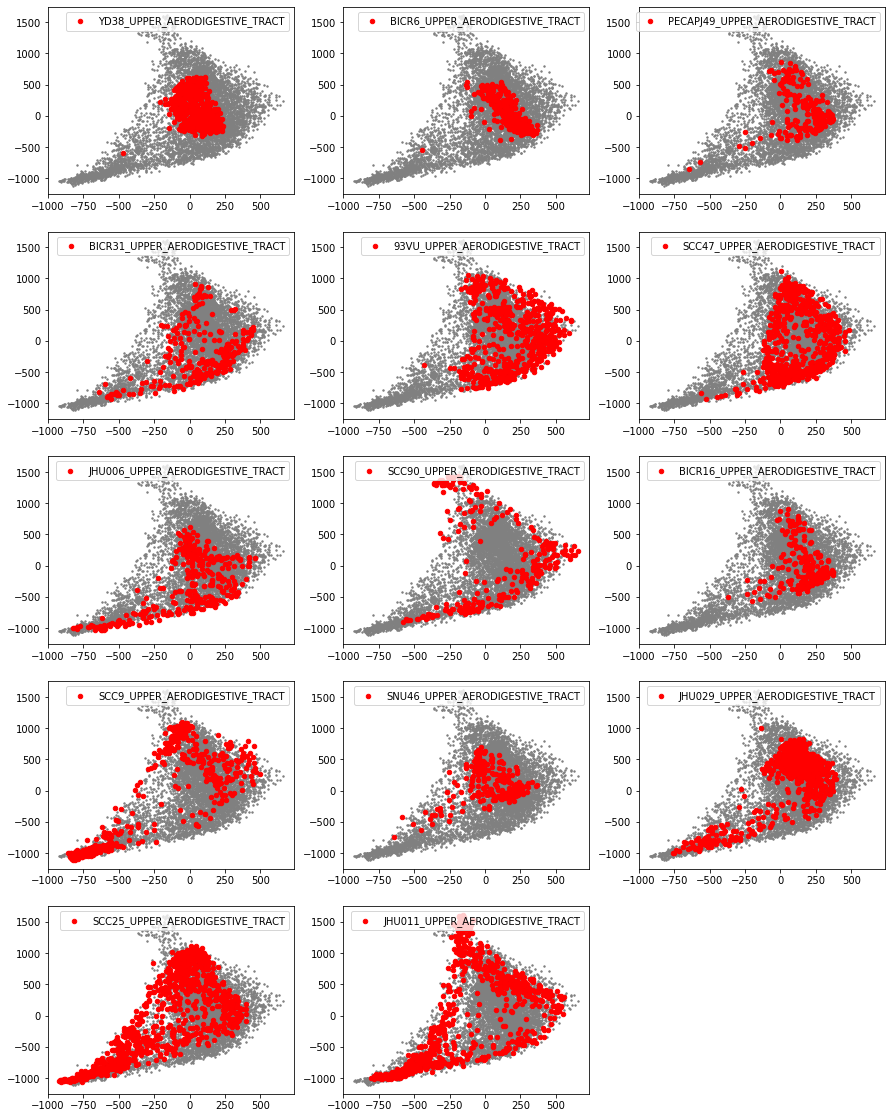

In [229]:
sx = 'hn_IC2'
sy = 'hn_IC3'
print(adata)

sc.pl.scatter(adata[:,:],x=sx,y=sy,color='CellLine')

hn_celllines = list(np.array(cell_lines)[ind])
hn_celllines_unique = list(set(hn_celllines))
plt.figure(figsize=(15,20))
k = 0
for v in hn_celllines_unique:
    if hn_celllines.count(v)>200:
        print(v,':',hn_celllines.count(v))
        ind1 = np.where(np.array(hn_celllines)==v)[0]
        #sc.pl.scatter(adata[ind1,:],x=sx,y=sy)
        x = adata[ind1,:].obs[sx]
        y = adata[ind1,:].obs[sy]
        xt = adata[:,:].obs[sx]
        yt = adata[:,:].obs[sy]        
        #plt.scatter(x,y,s=5,label=v)
        #if v.startswith('SCC47'):
        plt.subplot(5,3,k+1)
        k = k+1
        plt.scatter(xt,yt,s=2,c='grey')
        plt.scatter(x,y,s=20,label=v,c='r')
        plt.legend()
plt.show()

In [315]:
#cell_line = 'JHU029_UPPER_AERODIGESTIVE_TRACT'
cell_line = 'JHU011_UPPER_AERODIGESTIVE_TRACT'
#cell_line = 'SCC25_UPPER_AERODIGESTIVE_TRACT'
#cell_line = 'YD38_UPPER_AERODIGESTIVE_TRACT'
#cell_line = 'SCC47_UPPER_AERODIGESTIVE_TRACT'
ind_sel = np.where(adata.obs['CellLine']==cell_line)[0]
adata_sel = adata_orig[ind_sel,:]

if n_neighbours_for_pooling>0:
    adata_sel = pooling_procedure(adata_sel,adata_sel)
adata_sel = preprocessing_dataset(adata_sel)

dct = {'GENE':adata_sel.var_names}
for i,s in enumerate(adata_sel.obs_names):
    dct[s] = list(adata_sel.X[i,:])
pd.DataFrame(data=dct).to_csv(folder+cell_line+'.txt',sep='\t',index=False)

sc.pp.highly_variable_genes(adata_sel,n_top_genes=2001,n_bins=20)
ind_genes2k = np.where(adata_sel.var['highly_variable'])[0]
adata2k = adata_sel[:,ind_genes2k]
scores_dic_sel = calc_scores(adata2k,signature_dict)
scores_dic_sel['HISTONES'] = calc_histone_score(adata2k)

for s in scores_dic_sel:
    adata_sel.obs[s] = scores_dic_sel[s]

pd.DataFrame(data={'CELL':adata_sel.obs_names,'N_GENES_BY_COUNTS':adata_sel.obs['n_genes_by_counts']}).to_csv(folder+cell_line+'_NGENES.txt',sep='\t',index=False)

AnnData object with n_obs × n_vars = 717 × 10000
    obs: 'CellLine', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'log1p', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

Found histone genes: HIST1H4C HIST1H2BD HIST1H2BJ HIST1H2AC HIST1H1E HIST1H1D HIST2H2AC HIST1H1C H2AFX HIST1H1B H2AFZ HIST2H2BE HIST1H2BN H1F0 HIST3H2A HIST1H3G HIST1H2BC HIST1H2AE HIST1H2BH HIST1H3H HIST1H2AJ


In [291]:
sc.tl.pca(adata_sel,n_comps=number_of_pcs)
sc.pp.neighbors(adata_sel, n_neighbors=10)
sc.tl.umap(adata_sel)
sc.tl.tsne(adata_sel,perplexity=50)

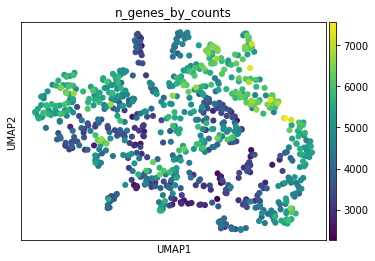

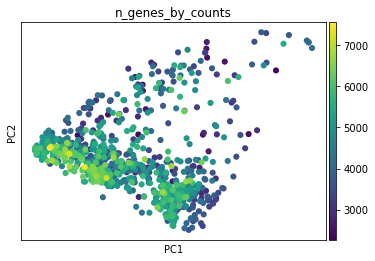

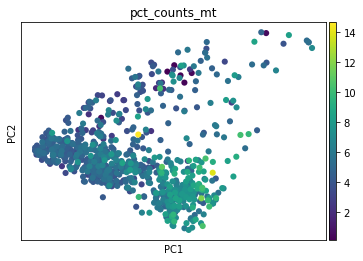

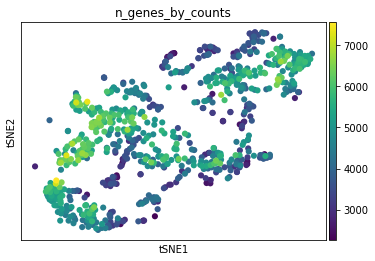

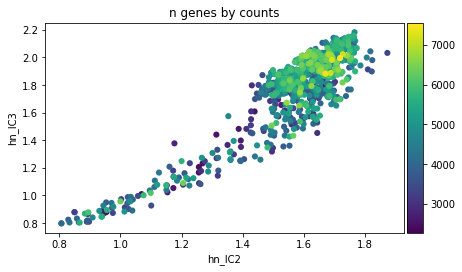

In [292]:
sc.pl.umap(adata_sel,color='n_genes_by_counts')
sc.pl.pca(adata_sel,color='n_genes_by_counts')
sc.pl.pca(adata_sel,color='pct_counts_mt')
sc.pl.tsne(adata_sel,color='n_genes_by_counts')
sc.pl.scatter(adata_sel,x='hn_IC2',y='hn_IC3',color='n_genes_by_counts')

In [359]:
sfile = folder+'JHU011_UPPER_AERODIGESTIVE_TRACT_ica_S.xls'
gmtfile = sfile[:-4]+'_weighted.gmt'
signature_dict = load_weighted_signature_file(gmtfile)
sc.pp.highly_variable_genes(adata_sel,n_top_genes=2001,n_bins=20)
ind_genes2k = np.where(adata_sel.var['highly_variable'])[0]
adata2k = adata_sel[:,ind_genes2k]
scores_dic = calc_weighted_scores(adata2k,signature_dict)
scores_dic['HISTONES'] = calc_histone_score(adata2k)

for s in scores_dic:
    adata_sel.obs[s] = scores_dic[s]

Found histone genes: HIST1H4C HIST1H2BD HIST1H2BJ HIST1H2AC HIST1H1E HIST1H1D HIST2H2AC HIST1H1C H2AFX HIST1H1B H2AFZ HIST2H2BE HIST1H2BN H1F0 HIST3H2A HIST1H3G HIST1H2BC HIST1H2AE HIST1H2BH HIST1H3H HIST1H2AJ


In [374]:
sfile = folder+'JHU011_UPPER_AERODIGESTIVE_TRACT_ica_S.xls'
gmtfile = sfile[:-4]+'.gmt'
signature_dict = load_signature_file(gmtfile)
sc.pp.highly_variable_genes(adata_sel,n_top_genes=2001,n_bins=20)
ind_genes2k = np.where(adata_sel.var['highly_variable'])[0]
adata2k = adata_sel[:,ind_genes2k]
scores_dic = calc_scores(adata2k,signature_dict)
scores_dic['HISTONES'] = calc_histone_score(adata2k)

for s in scores_dic:
    adata_sel.obs[s] = scores_dic[s]

Found histone genes: HIST1H4C HIST1H2BD HIST1H2BJ HIST1H2AC HIST1H1E HIST1H1D HIST2H2AC HIST1H1C H2AFX HIST1H1B H2AFZ HIST2H2BE HIST1H2BN H1F0 HIST3H2A HIST1H3G HIST1H2BC HIST1H2AE HIST1H2BH HIST1H3H HIST1H2AJ


The initial number of nodes must be at least 3. This will be fixed
Generating the initial configuration
Creating a circle in the plane induced by the 1st and 2nd PCs with 3 nodes
90% of the points have been used as initial conditions. Resetting.
Constructing tree 1 of 1 / Subset 1 of 1
Performing PCA
Using standard PCA
4 dimensions are being used
100.0 % of the original variance has been retained
The elastic matrix is being used. Edge configuration will be ignored
Computing EPG with  30  nodes on  717  points and  4  dimensions
Nodes =  3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 

BARCODE	ENERGY	NNODES	NEDGES	NRIBS	NSTARS	NRAYS	NRAYS2	MSE	MSEP	FVE	FVEP	UE	UR	URN	URN2	URSD

0||30	26889.2186	30	30	30	0	0	0	13754.5629	11651.8115	0.9808	0.9837	10405.8948	2728.7609	81862.827	2455884.8106	0


MSDEnergyPlot not yet implemented
accuracyComplexityPlot not yet implemented
0.4875  seconds elapsed


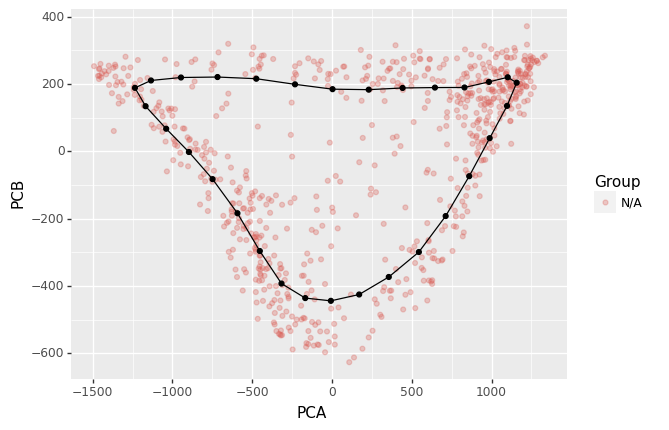

[<ggplot: (8781433909957)>]


In [360]:
# ElPiGraph analysis

import elpigraph

cell_cycle_ics_data = pd.DataFrame(data={'hn_IC2':adata_sel.obs['hn_IC2'],'hn_IC3':adata_sel.obs['hn_IC3'],
                                         'hn_IC8':adata_sel.obs['hn_IC8'],'hn_IC10':adata_sel.obs['hn_IC10']}).to_numpy().astype(np.float64)

egr = elpigraph.computeElasticPrincipalCircle(cell_cycle_ics_data,30)

Suggested edge to remove 20
Selected edge to remove 25


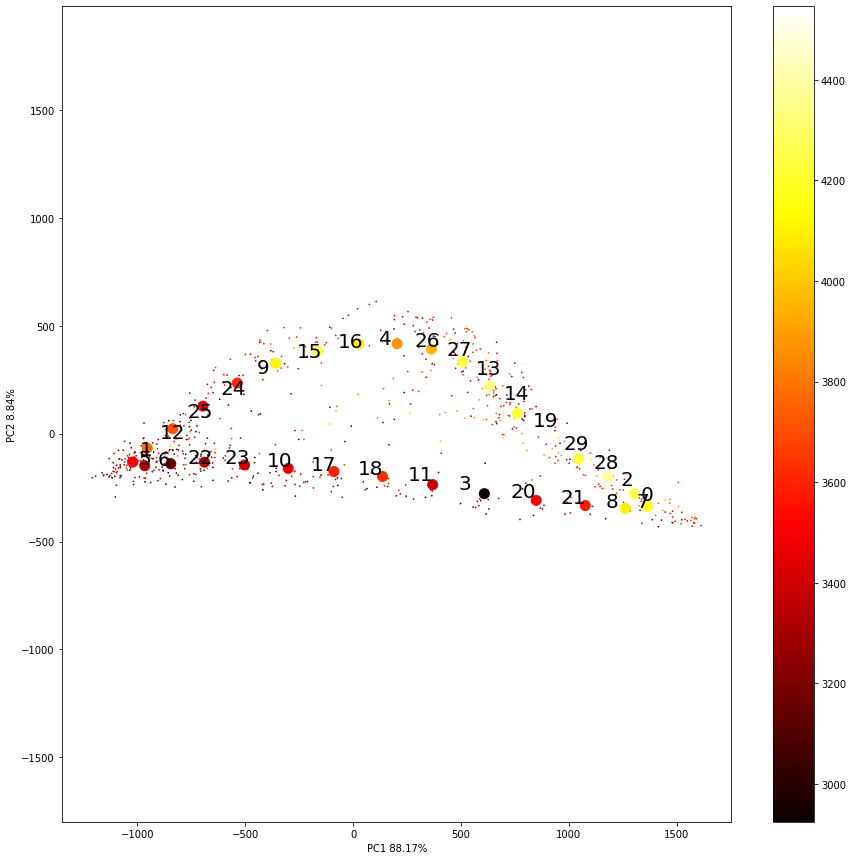

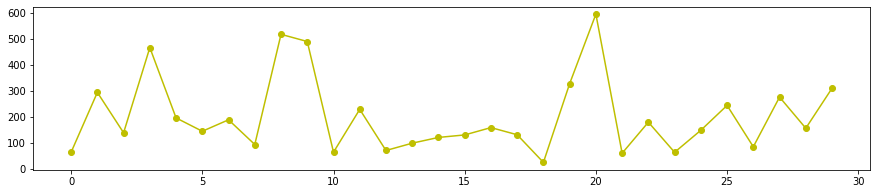

In [361]:
partition, dists = elpigraph.src.core.PartitionData(X = cell_cycle_ics_data, NodePositions = egr[0]['NodePositions'], MaxBlockSize = 100000000, TrimmingRadius = np.inf,SquaredX = np.sum(cell_cycle_ics_data**2,axis=1,keepdims=1))
ProjStruct = elpigraph.src.reporting.project_point_onto_graph(X = cell_cycle_ics_data,
                                     NodePositions = egr[0]['NodePositions'],
                                     Edges = egr[0]['Edges'][0],
                                     Partition = partition)

pca = PCA()
mean_vector = np.mean(cell_cycle_ics_data)
u = pca.fit_transform(cell_cycle_ics_data)
v = pca.components_.T
s = pca.explained_variance_

nodep = egr[0]['NodePositions']
edges = egr[0]['Edges'][0]
nodep_pca = np.matmul(nodep-mean_vector,v)


total_counts = adata_sel[:,:].obs['n_genes_by_counts'].to_numpy()
node_read_counts = np.zeros(nodep.shape[0])
edge_abs_diff_counts = np.zeros(len(edges))
for i in range(len(nodep)):
    node_read_counts[i] = np.mean(total_counts[np.where(partition==i)[0]])
for i,e in enumerate(edges):
    edge_abs_diff_counts[i] = np.abs(node_read_counts[e[0]]-node_read_counts[e[1]])

plt.figure(figsize=(15,15))
plt.scatter(u[:,0],u[:,1],c=total_counts,s=0.5,cmap='hot')
plt.scatter(nodep_pca[:,0],nodep_pca[:,1],c=node_read_counts,s=100,cmap='hot')
#for i in range(len(nodep)):
#    plt.text(nodep_pca[i,0],nodep_pca[i,1],str(i),fontsize=20)
for i,e in enumerate(edges):
    mn_posx = np.mean(nodep_pca[e,0])
    mn_posy = np.mean(nodep_pca[e,1])
    plt.text(mn_posx,mn_posy,str(i),fontsize=20)

plt.axis('equal')
plt.colorbar()
plt.xlabel('PC1 {:.2f}%'.format(s[0]/np.sum(s)*100))
plt.ylabel('PC2 {:.2f}%'.format(s[1]/np.sum(s)*100))
plt.axis('equal')
#plt.title(score_name)
    
plt.figure(figsize=(15,3))
plt.plot(edge_abs_diff_counts,'yo-')

print('Suggested edge to remove',np.argmax(edge_abs_diff_counts))
edge_to_remove = 25
print('Selected edge to remove',edge_to_remove)

[ 7 15]
7
[7, 25, 5, 11, 19, 23, 3, 17, 26, 9, 13, 1, 6, 20, 27, 16, 0, 22, 12, 8, 28, 14, 21, 18, 24, 29, 10, 4, 2]


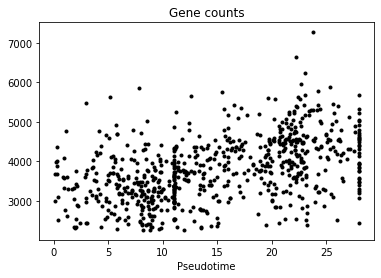

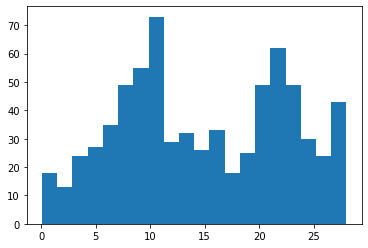

In [373]:
from elpigraph_ps_tools import *

edge_to_remove = 7

X_elpigraph_training = cell_cycle_ics_data

gr = egr[0].copy()
starting_node = edges[edge_to_remove,0]
print(edges[edge_to_remove])
print(starting_node)
edges = np.delete(gr['Edges'][0],edge_to_remove,axis=0)
w1 = np.delete(gr['Edges'][1],edge_to_remove,axis=0)
w2 = np.delete(gr['Edges'][2],edge_to_remove,axis=0)
gr['Edges'] = (edges,w1,w2)

traj = extract_trajectories(gr,starting_node,verbose=False)[0]
print(traj)

ProjStruct = project_on_tree(X_elpigraph_training,gr)
#pseudo_time_trajectory(traj,ProjStruct)
PseudoTimeTraj = quantify_pseudotime([traj],ProjStruct,producePlot=False)
points = PseudoTimeTraj[0]['Points'] 
pst = PseudoTimeTraj[0]['Pseudotime']

plt.plot(pst,total_counts[points],'k.')
plt.xlabel('Pseudotime')
plt.title('Gene counts')
plt.show()

plt.hist(pst,bins=20)
plt.show()

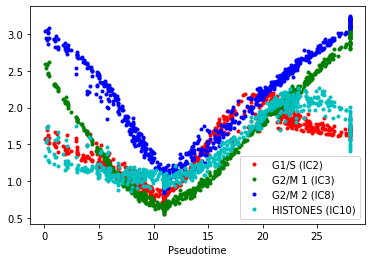

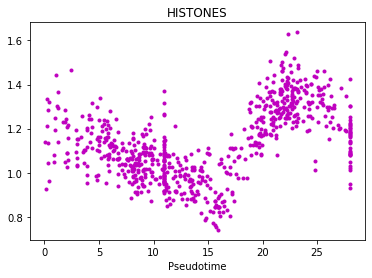

AnnData object with n_obs × n_vars = 717 × 10000
    obs: 'CellLine', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'hn_IC1', 'hn_IC2', 'hn_IC3', 'hn_IC4', 'hn_IC5', 'hn_IC6', 'hn_IC7', 'hn_IC8', 'hn_IC9', 'hn_IC10', 'hn_IC11', 'hn_IC12', 'hn_IC13', 'hn_IC14', 'hn_IC15', 'HISTONES'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'


In [377]:
plt.plot(pst,scores_dic['hn_IC2'][points],'r.',label='G1/S (IC2)')
plt.plot(pst,scores_dic['hn_IC3'][points],'g.',label='G2/M 1 (IC3)')
plt.plot(pst,scores_dic['hn_IC8'][points],'b.',label='G2/M 2 (IC8)')
plt.plot(pst,scores_dic['hn_IC10'][points],'c.',label='HISTONES (IC10)')
plt.legend()
plt.xlabel('Pseudotime')
plt.show()
plt.plot(pst,scores_dic['HISTONES'][points],'m.')
plt.title('HISTONES')
plt.xlabel('Pseudotime')
plt.show()

print(adata_sel)

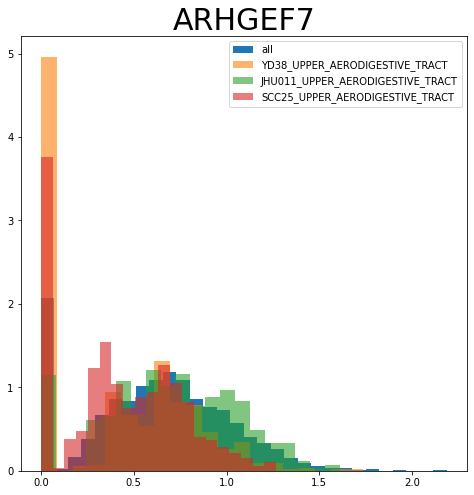

In [299]:
#selected_cell_lines = ['YD38_UPPER_AERODIGESTIVE_TRACT','JHU011_UPPER_AERODIGESTIVE_TRACT','BICR6_UPPER_AERODIGESTIVE_TRACT','SCC47_UPPER_AERODIGESTIVE_TRACT']
selected_cell_lines = ['YD38_UPPER_AERODIGESTIVE_TRACT','JHU011_UPPER_AERODIGESTIVE_TRACT','SCC25_UPPER_AERODIGESTIVE_TRACT']
#selected_cell_lines = ['SCC25_UPPER_AERODIGESTIVE_TRACT','YD38_UPPER_AERODIGESTIVE_TRACT','SNU46_UPPER_AERODIGESTIVE_TRACT']

#gene = 'MKI67'
#gene = 'CCNB1'
#gene = 'HIST1H4C'
#gene = 'CDK1'
#gene = 'AURKB'
#gene = 'SOS1'
gene = 'ARHGEF7'
hn_celllines = list(np.array(cell_lines)[ind])
ind_gene = list(adata.var_names).index(gene)
plt.figure(figsize=(8,8))
#plt.hist(adata.X[np.where(adata.X[:,ind_gene]>0)[0],ind_gene],bins=50,label='all',density=True)
plt.hist(adata.X[:,ind_gene],bins=30,label='all',density=True)
for cl in selected_cell_lines:
    ind1 = np.where(np.array(hn_celllines)==cl)[0]
    plt.hist(adata.X[ind1,ind_gene],bins=20,label=cl,alpha=0.6,density=True)
plt.legend()
plt.title(gene,fontsize=30)
plt.show()

Text(0.5, 1.0, 'UBE2C')

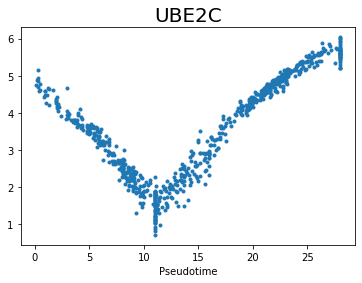

In [394]:
#gene = 'UBE2C'
#gene = 'HIST1H4C'
gene = 'UBE2C'
hn_celllines = list(np.array(cell_lines)[ind])
ind_gene = list(adata_sel.var_names).index(gene)
#plt.figure(figsize=(8,8))
plt.plot(pst,adata_sel.X[points,ind_gene],'.')
plt.xlabel('Pseudotime')
plt.title(gene,fontsize=20)